In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [54]:
stockname = input("Enter Stock Name:")
data = pd.read_csv(stockname+'.csv')


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6611 entries, 0 to 6610
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6611 non-null   object 
 1   Open       6611 non-null   float64
 2   High       6611 non-null   float64
 3   Low        6611 non-null   float64
 4   Close      6611 non-null   float64
 5   Adj Close  6611 non-null   float64
 6   Volume     6611 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 361.7+ KB


In [56]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6611 entries, 0 to 6610
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6611 non-null   datetime64[ns]
 1   Open       6611 non-null   float64       
 2   High       6611 non-null   float64       
 3   Low        6611 non-null   float64       
 4   Close      6611 non-null   float64       
 5   Adj Close  6611 non-null   float64       
 6   Volume     6611 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 361.7 KB


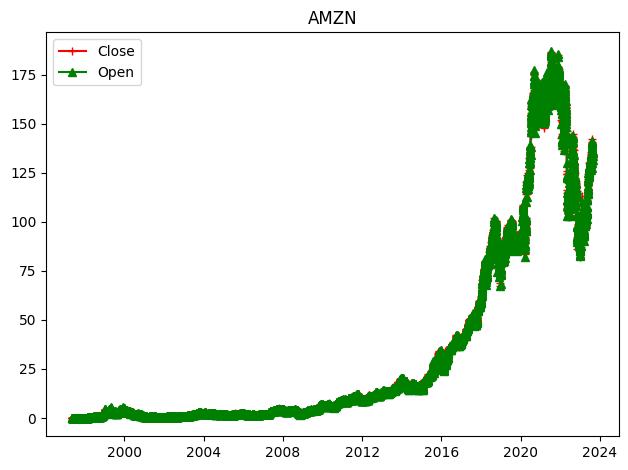

In [57]:
plt.plot(data['Date'], data['Close'], c="r", label="Close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="Open", marker="^")
plt.title(stockname)
plt.legend()
plt.tight_layout()
plt.show()  

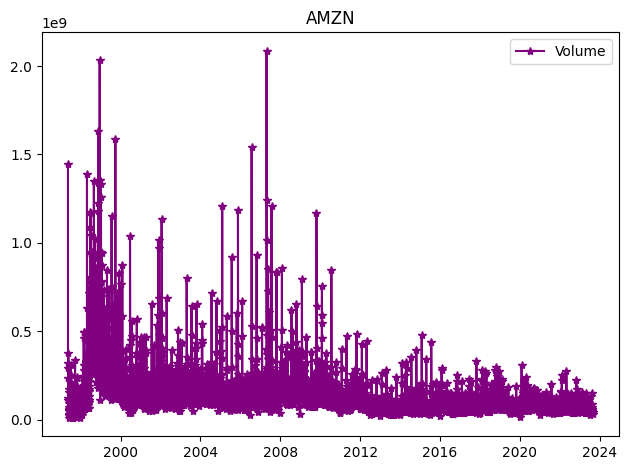

In [58]:
plt.plot(data['Date'], data['Volume'], c='purple', marker='*', label='Volume')
plt.title(stockname)
plt.legend()
plt.tight_layout()
plt.show()  

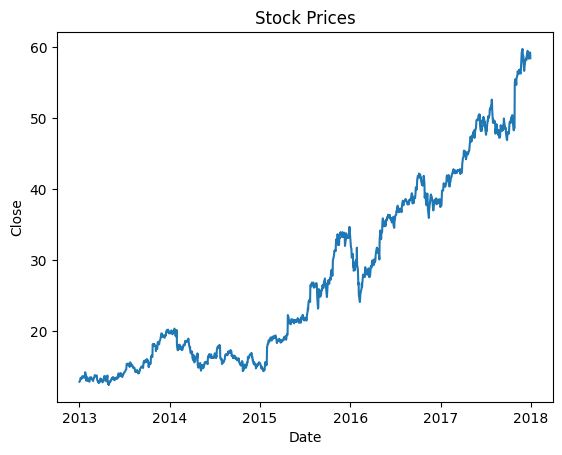

In [59]:

stock_data = data.copy()

# Date filter
prediction_range = stock_data.loc[(stock_data['Date'] > datetime(2013,1,1))
                                 & (stock_data['Date']<datetime(2018,1,1))]

# Plotting
plt.plot(prediction_range['Date'], prediction_range['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Stock Prices")  # Keeping the title generic since we're not filtering by ticker
plt.show()


In [60]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)
print(close_data.shape)
print(dataset.shape)

6281
(6611, 1)
(6611, 1)


In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [62]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1), dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 128)           66560     
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 206465 (806.50 KB)
Trainable params: 206465 (806.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check the loss
    if(logs.get('loss') < 0.4):

      # Stop if threshold is met
      print("\nLoss is lower than 0.4 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=10, callbacks=[callbacks])



Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.0075
Loss is lower than 0.4 so cancelling training!
195/195 [==============================] - 29s 140ms/step - loss: 0.0075


In [64]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

11/11 [==============================] - 0s 19ms/step
MSE 122.71468669258465
RMSE 11.077666121191081


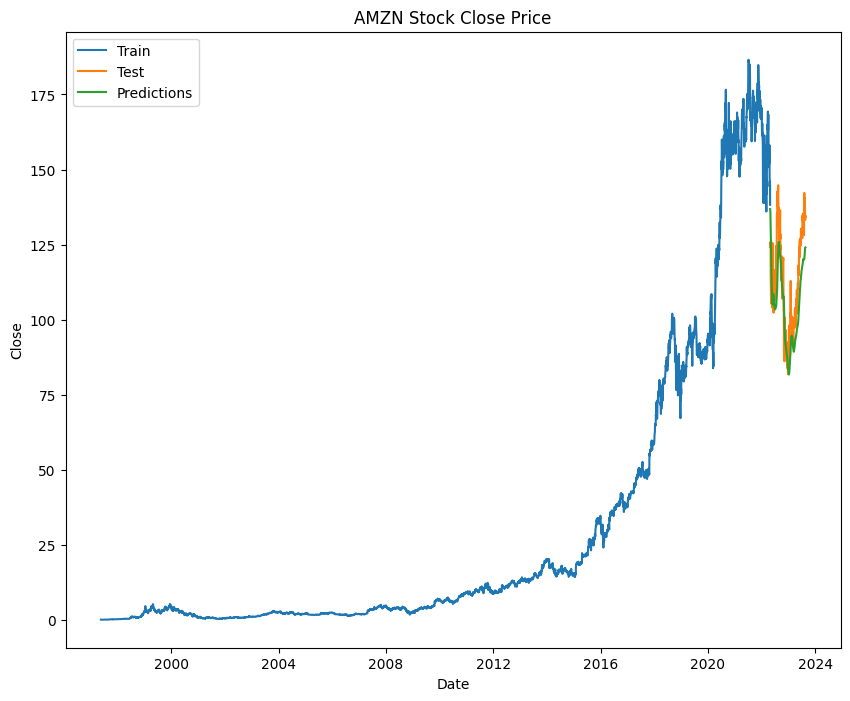

In [65]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title(stockname +  ' Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])